# Clinical Data Visualization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings('ignore')
sns.set_context("paper")
colors = sns.color_palette("muted", 10)
dpi = 600

In [2]:
# 评价指标函数
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def RMSE(pred, true):
    pred = pred.values.flatten()
    true = true.values.flatten()
    rmse = ((pred - true) ** 2).mean() ** 0.5
    return rmse


def MSE(pred, true):
    pred = pred.values.flatten()
    true = true.values.flatten()
    mse = ((pred - true) ** 2).mean()
    return mse


def CCCscore(y_pred, y_true, mode='all'):
    # pred: shape{n sample, m cell}
    if mode == 'all':
        y_pred = y_pred.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)
    elif mode == 'avg':
        pass
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]


def plot_ccc_comparison(data, metric='CCC', filename=None):
    # 创建一个副本以避免修改原始 DataFrame
    data_to_plot = data.copy()

    # 1. 定义新旧标签的映射关系
    label_map = {
        'Bcells': 'B cell',
        'CD4Tcells': 'CD4 T cell',
        'CD8Tcells': 'CD8 T cell',
        'Monocytes': 'Monocyte',
        'NK': 'NK cell',
        'Unknown': 'Unknown'
    }

    # 2. 将映射应用到 'CellType' 列
    # .get(x, x) ensures that if a cell type is not in the map, it remains unchanged
    data_to_plot['CellType'] = data_to_plot['CellType'].apply(lambda x: label_map.get(x, x))

    plt.figure(figsize=(10, 4))
    # 使用修改后的 data_to_plot 进行绘图
    ax = sns.barplot(data=data_to_plot, x="CellType", y=metric, hue="Method", palette=colors, ci=None)

    # 设置图表标题和标签
    # plt.title("Cell Type CCC by Method and Dataset",
    #           fontsize=14, pad=20)
    # plt.xlabel("Cell Type", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    # 调整图例位置和字体大小
    plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')

    # 旋转x轴标签以避免重叠
    # plt.xticks(rotation=45, ha='right')
    ax.set_xlabel("")

    # 设置y轴范围
    # plt.ylim(0, 1)

    # 添加网格线
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # 调整布局防止标签被截断
    plt.tight_layout()
    plt.savefig(f"{filename}_{metric}_comparison.png", dpi=dpi, bbox_inches='tight')
    plt.show()


def plot_boxplot(data, order, filename, show_points=True):
    """
    以 2x4 网格形式绘制箱线图。

    参数:
    data (pd.DataFrame): 包含 'Method', 'CCC', 和 'Dataset' 列的数据。
    order (list): 指定 'Method' 在 x 轴上的显示顺序。
    show_points (bool): 是否显示离群数据点 (fliers)。默认为 True。
    """

    sns.set_style("whitegrid")
    """绘制CCC"""
    g = sns.catplot(
        x="Method", y="CCC",
        col="Dataset",
        data=data,
        kind="box",
        order=order,
        col_wrap=4,  # 每行显示4个子图
        palette=colors,
        height=4,  # 每个子图的高度
        aspect=1.2,
        showfliers=show_points,
        linewidth=0.8,
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("CCC")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_CCC.png", dpi=dpi, bbox_inches='tight')
    plt.show()

    """绘制MAE"""
    g = sns.catplot(
        x="Method", y="MAE",
        col="Dataset",
        data=data,
        kind="box",
        order=order,
        col_wrap=4,
        palette=colors,
        height=4,
        aspect=1.2,
        showfliers=show_points,
        linewidth=0.8,  # 轮廓线宽度
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("MAE")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_MAE.png", dpi=dpi, bbox_inches='tight')
    plt.show()


def plot_violin(data, order, filename=None, show_points=True):
    """
    以 2x4 网格形式绘制小提琴图。

    参数:
    data (pd.DataFrame): 包含 'Method', 'CCC', 和 'Dataset' 列的数据。
    order (list): 指定 'Method' 在 x 轴上的显示顺序。
    """

    sns.set_style("whitegrid")
    """绘制CCC"""
    g = sns.catplot(
        x="Method", y="CCC",
        col="Dataset",
        data=data,
        kind="violin",
        order=order,
        col_wrap=4,  # 每行显示4个子图
        palette=colors,
        height=4,  # 每个子图的高度
        aspect=1.2,
        linewidth=0.8,
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("CCC")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_CCC.png", dpi=dpi, bbox_inches='tight')
    plt.show()

    """绘制MAE"""
    g = sns.catplot(
        x="Method", y="MAE",
        col="Dataset",
        data=data,
        kind="violin",
        order=order,
        col_wrap=4,
        palette=colors,
        height=4,
        aspect=1.2,
        linewidth=0.8,  # 轮廓线宽度
        sharex=False  # <--- 这是最关键的修正！
    )
    # 设置子图的标题和Y轴标签
    g.set_titles("{col_name}")
    g.set_ylabels("MAE")
    # 遍历每个子图的 axes，进行精细调整
    for ax in g.axes.flat:
        # 旋转每个子图的X轴刻度标签
        ax.tick_params(axis='x', labelrotation=45)
        # 为每个子图设置X轴的标题
        # ax.set_xlabel("Method")
        ax.set_xlabel("")
    # 调整整体布局，防止标签或标题重叠
    plt.tight_layout()
    # 如果需要保存图片
    plt.savefig(f"{filename}_MAE.png", dpi=dpi, bbox_inches='tight')
    plt.show()


def plot_trend_box(data, name, x, y, xlabel, ylabel, filename):
    sns.set_style("white")
    fig, axes = plt.subplots(1, len(data), figsize=(14, 4), sharex=True, sharey=True)

    # fig, axes = plt.subplots(2, 4, figsize=(14, 8)) # 调整figsize适应新布局
    # axes = axes.flatten() # 将2x4的axes数组展平，方便继续使用 for i in range(...) 索引

    for i in range(len(data)):
        sns.stripplot(x=x, y=y, data=data[i], ax=axes[i], color=colors[i], marker='.')
        # sns.swarmplot(x=x,y=y,data=data[i],ax=axes[i],color=colors[i],size=2.5)
        sns.boxplot(x=x, y=y, data=data[i], ax=axes[i], color=colors[i], fliersize=0.1, linewidth=1)

        axes[i].set(xlabel=None, ylabel=None)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        # axes[i].yaxis.set_major_locator(y_major_locator)
        if i >= 1:
            axes[i].spines['left'].set_visible(False)
            axes[i].yaxis.set_visible(False)
            # axes[i].set_yticklabels([])
        axes[i].set_title(name[i])

        sns.regplot(  # 添加回归线
            x=x, y=y, data=data[i], ax=axes[i],
            ci=None,  # <--- 添加这一行来取消置信区间
            scatter=False,  # 不再重复绘制散点
            color='red',  # 使用统一的深色线条
            line_kws={'lw': 0.8, 'ls': '--'}  # 设置线条样式，例如虚线
        )
        axes[i].set(xlabel=None, ylabel=None)
    # plt.ylim(0,0.3)
    fig.supxlabel(xlabel)
    fig.supylabel(ylabel)
    plt.tight_layout()
    fig.savefig(f"{filename}.png", dpi=dpi)
    plt.show()


## Brain_human

In [3]:
dataset_list = ['brain_human']
# method_list = ['BIND', 'DeSide', 'BayesPrism', 'CIBERSORTX', 'ReDeconv', 'Scaden', 'scpDeconv', 'TAPE-O', 'TAPE-H']
method_list = ['BIND', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

dataset_dict = {'brain_human': 'Brain_human'}

overall_results = []
celltype_results = []

for method in method_list:
    for dataset in dataset_list:
        print(f"############################## {method}: {dataset} ##############################")
        pred = pd.read_csv(f'../results/predicted/{method}/{dataset}.txt', sep='\t', index_col=0, header=0)
        label = pd.read_csv('../data/Real bulk/truth/' + dataset + '_truth.csv', index_col=0, header=0)

        pred.sort_index(axis=1, inplace=True)
        label.sort_index(axis=1, inplace=True)

        inter = pred.columns.intersection(label.columns)
        label = label[inter]
        pred = pred[inter]
        label = label / label.sum(axis=1).values.reshape(-1, 1)
        pred = pred / pred.sum(axis=1).values.reshape(-1, 1)

        overall_ccc = CCCscore(label.values, pred.values)
        overall_mae = MAE(label.values, pred.values)
        print('Overall CCC score is', overall_ccc)
        print('Overall MAE is', overall_mae)
        overall_results.append(
            {'Overall_CCC': overall_ccc, 'Overall_MAE': overall_mae, 'Dataset': dataset_dict[dataset],
             'Method': method})
        for i in range(pred.shape[1]):
            ccc = CCCscore(label.iloc[:, i].values, pred.iloc[:, i].values)
            mae = MAE(label.iloc[:, i].values, pred.iloc[:, i].values)
            celltype = pred.columns[i]
            print(celltype + "'s CCC score is", ccc, "MAE is", mae)
            celltype_results.append({'CellType': celltype, 'CCC': ccc, 'MAE': mae,
                                     'Dataset': dataset_dict[dataset], 'Method': method})


############################## BIND: brain_human ##############################
Overall CCC score is 0.8022484316776461
Overall MAE is 0.06574518743522205
Astrocytes's CCC score is 0.17109053776946392 MAE is 0.06841459876675433
Endothelial's CCC score is 0.0022408852771525828 MAE is 0.0756797929757096
Microglia's CCC score is 0.22773936995668234 MAE is 0.018682241694048245
Neurons's CCC score is 0.27970723953967946 MAE is 0.0805700355687508
Oligodendrocytes's CCC score is 0.07047035082044355 MAE is 0.08537926817084728
############################## DeSide: brain_human ##############################
Overall CCC score is 0.8810617602910641
Overall MAE is 0.0640773410208957
Astrocytes's CCC score is 0.37956329531650684 MAE is 0.03828469649679076
Endothelial's CCC score is -0.009020830227055774 MAE is 0.03547850157819264
Microglia's CCC score is 0.12514867202062777 MAE is 0.03739585912899225
Neurons's CCC score is 0.1932863382016626 MAE is 0.12416072802691401
Oligodendrocytes's CCC score i

In [4]:
celltype_results = pd.DataFrame(celltype_results)
order = ['BIND', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

In [5]:
celltype_mapping = {
    'Astrocytes': 'Astrocyte',
    'Endothelial': 'Endothelial cell',
    'Microglia': 'Microglial cell',
    'Neurons': 'Neuron',
    'Oligodendrocytes': 'Oligodendrocyte'
}
celltype_results['CellType'] = celltype_results['CellType'].apply(lambda x: celltype_mapping.get(x, x))
celltype_results.head()

,CellType,CCC,MAE,Dataset,Method
0,Astrocyte,0.171091,0.068415,Brain_human,BIND
1,Endothelial cell,0.002241,0.075680,Brain_human,BIND
2,Microglial cell,0.227739,0.018682,Brain_human,BIND
3,Neuron,0.279707,0.080570,Brain_human,BIND
4,Oligodendrocyte,0.070470,0.085379,Brain_human,BIND


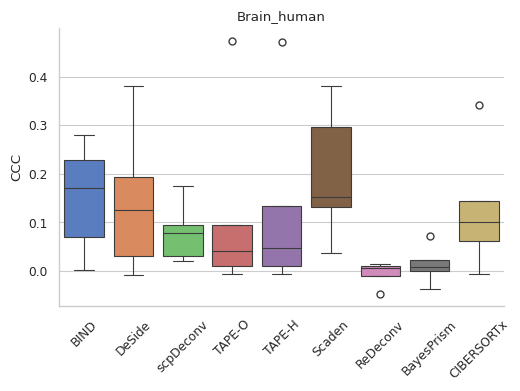

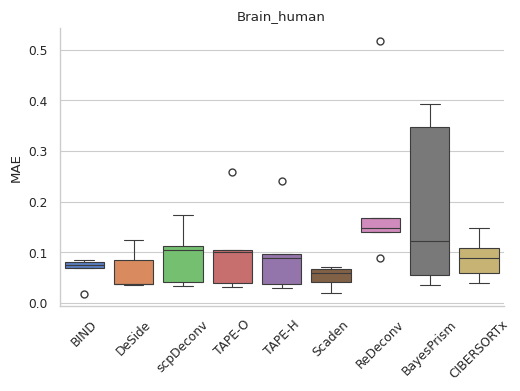

In [6]:
plot_boxplot(celltype_results, order, '../results/plot/Brain_human_boxplot')

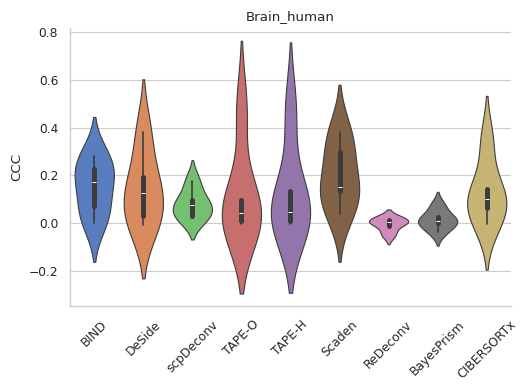

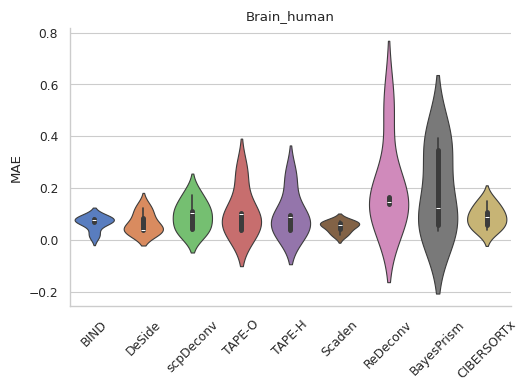

In [7]:
plot_violin(celltype_results, order, filename='../results/plot/Brain_human_violin')

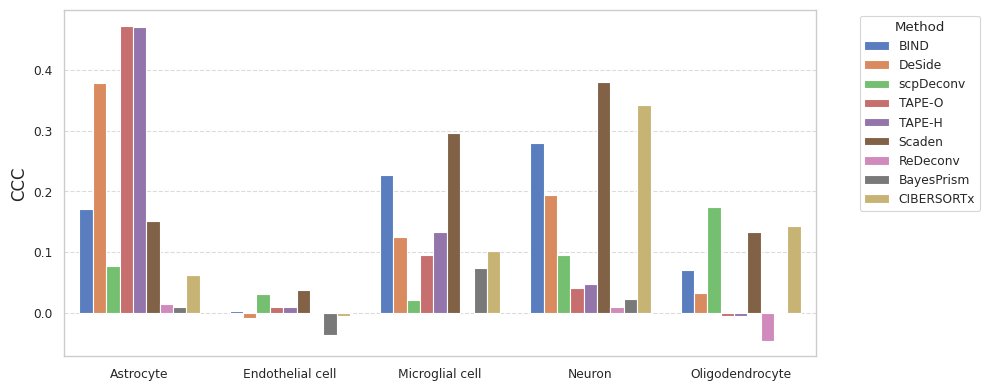

In [8]:
plot_ccc_comparison(celltype_results, metric='CCC', filename='../results/plot/Brain_human')

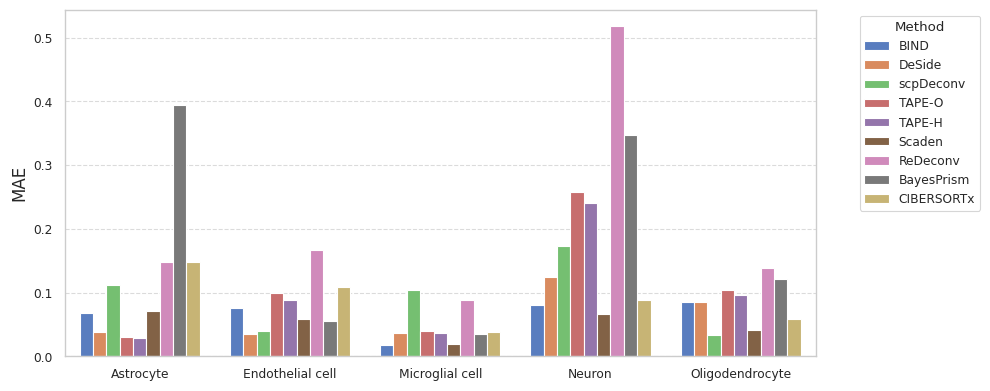

In [9]:
plot_ccc_comparison(celltype_results, metric='MAE', filename='../results/plot/Brain_human')

In [10]:
brain_human = pd.read_csv('../data/Real bulk/brain_human_541.txt', sep='\t', index_col=0, header=0).T
brain_human.index = brain_human.index.astype(int)
IDkey = pd.read_csv('../data/Real bulk/truth/brain_human_clinical.txt', sep='\t')
BIND = pd.read_csv('../results/predicted/BIND/brain_human_541.txt', sep='\t', index_col=0, header=0)
DeSide = pd.read_csv('../results/predicted/DeSide/brain_human_541.txt', sep='\t', index_col=0, header=0)
BayesPrism = pd.read_csv('../results/predicted/BayesPrism/brain_human_541.txt', sep='\t', index_col=0, header=0)
CIBERSORTX = pd.read_csv('../results/predicted/CIBERSORTx/brain_human_541.txt', sep='\t', index_col=0, header=0)
CIBERSORTX.drop(columns=['P-value', 'Correlation', 'RMSE'], inplace=True)
ReDeconv = pd.read_csv('../results/predicted/ReDeconv/brain_human_541.txt', sep='\t', index_col=0, header=0)
Scaden = pd.read_csv('../results/predicted/Scaden/brain_human_541.txt', sep='\t', index_col=0, header=0)
scpDeconv = pd.read_csv('../results/predicted/scpDeconv/brain_human_541.txt', sep='\t', index_col=0, header=0)
TAPE_O = pd.read_csv('../results/predicted/TAPE-O/brain_human_541.txt', sep='\t', index_col=0, header=0)
TAPE_H = pd.read_csv('../results/predicted/TAPE-H/brain_human_541.txt', sep='\t', index_col=0, header=0)

In [11]:
BIND.index = brain_human.index
BayesPrism.index = brain_human.index
scpDeconv.index = brain_human.index

In [12]:
BIND = BIND[BIND.index.isin(IDkey['projid.x'])]
DeSide = DeSide[DeSide.index.isin(IDkey['projid.x'])]
BayesPrism = BayesPrism[BayesPrism.index.isin(IDkey['projid.x'])]
CIBERSORTX = CIBERSORTX[CIBERSORTX.index.isin(IDkey['projid.x'])]
ReDeconv = ReDeconv[ReDeconv.index.isin(IDkey['projid.x'])]
Scaden = Scaden[Scaden.index.isin(IDkey['projid.x'])]
scpDeconv = scpDeconv[scpDeconv.index.isin(IDkey['projid.x'])]
TAPE_O = TAPE_O[TAPE_O.index.isin(IDkey['projid.x'])]
TAPE_H = TAPE_H[TAPE_H.index.isin(IDkey['projid.x'])]

IDkey2 = IDkey[IDkey['projid.x'].isin(BIND.index)]

In [13]:
IDkey2.shape

(493, 22)

In [14]:
# 根据BIND.index和IDkey2['projid.x']进行匹配，来增加BIND['braaksc']列
BIND['braaksc'] = IDkey2.set_index('projid.x').reindex(BIND.index)['braaksc'].values
DeSide['braaksc'] = IDkey2.set_index('projid.x').reindex(DeSide.index)['braaksc'].values
BayesPrism['braaksc'] = IDkey2.set_index('projid.x').reindex(BayesPrism.index)['braaksc'].values
CIBERSORTX['braaksc'] = IDkey2.set_index('projid.x').reindex(CIBERSORTX.index)['braaksc'].values
ReDeconv['braaksc'] = IDkey2.set_index('projid.x').reindex(ReDeconv.index)['braaksc'].values
Scaden['braaksc'] = IDkey2.set_index('projid.x').reindex(Scaden.index)['braaksc'].values
scpDeconv['braaksc'] = IDkey2.set_index('projid.x').reindex(scpDeconv.index)['braaksc'].values
TAPE_O['braaksc'] = IDkey2.set_index('projid.x').reindex(TAPE_O.index)['braaksc'].values
TAPE_H['braaksc'] = IDkey2.set_index('projid.x').reindex(TAPE_H.index)['braaksc'].values

In [15]:
BIND.shape

(493, 6)

In [16]:
data = [BIND, DeSide, scpDeconv, TAPE_O, TAPE_H, Scaden, ReDeconv, BayesPrism, CIBERSORTX]
name = ['BIND', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

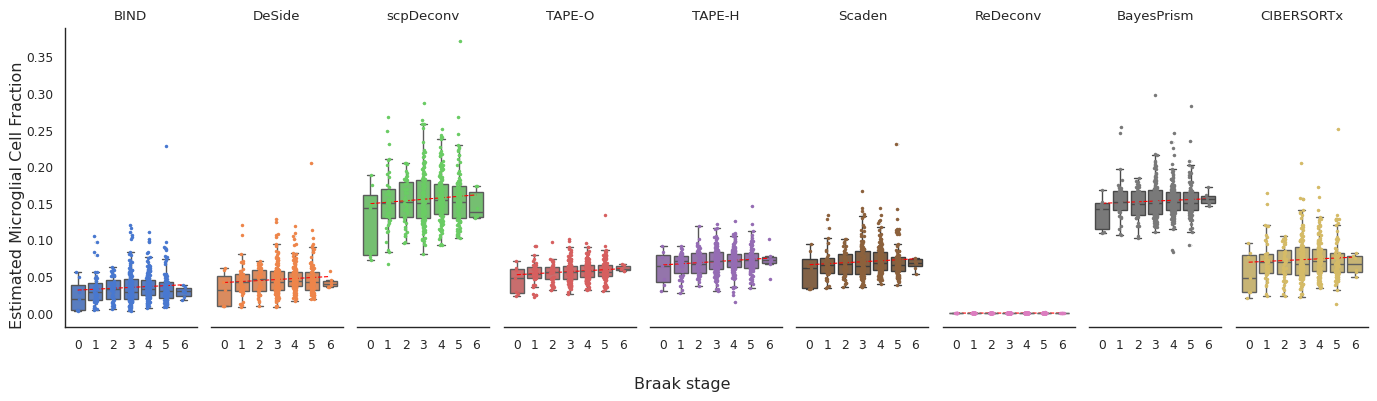

In [17]:
plot_trend_box(data, name, x='braaksc', y='Microglia', xlabel='Braak stage', ylabel='Estimated Microglial Cell Fraction',
               filename='../results/plot/Brain_human_microglia_braak')

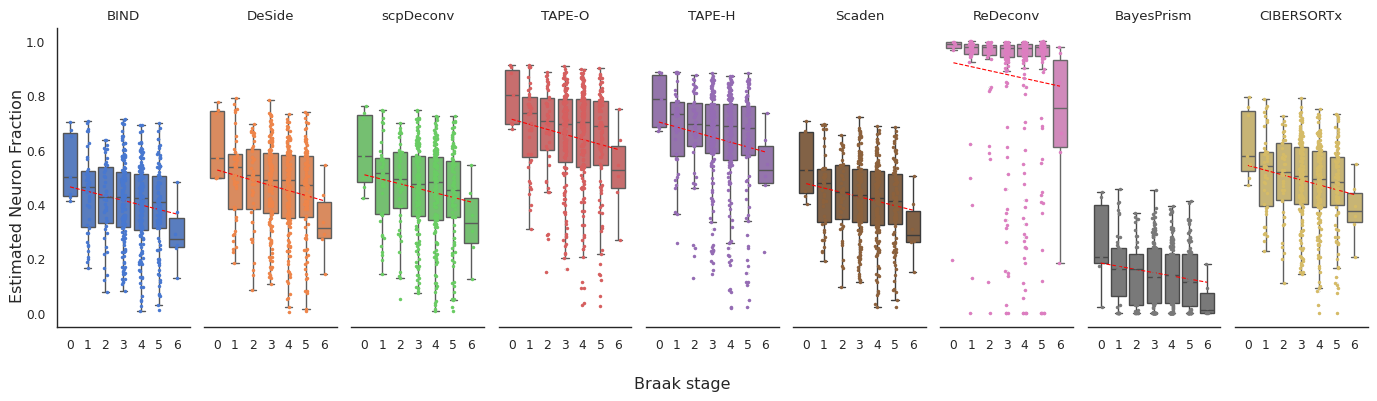

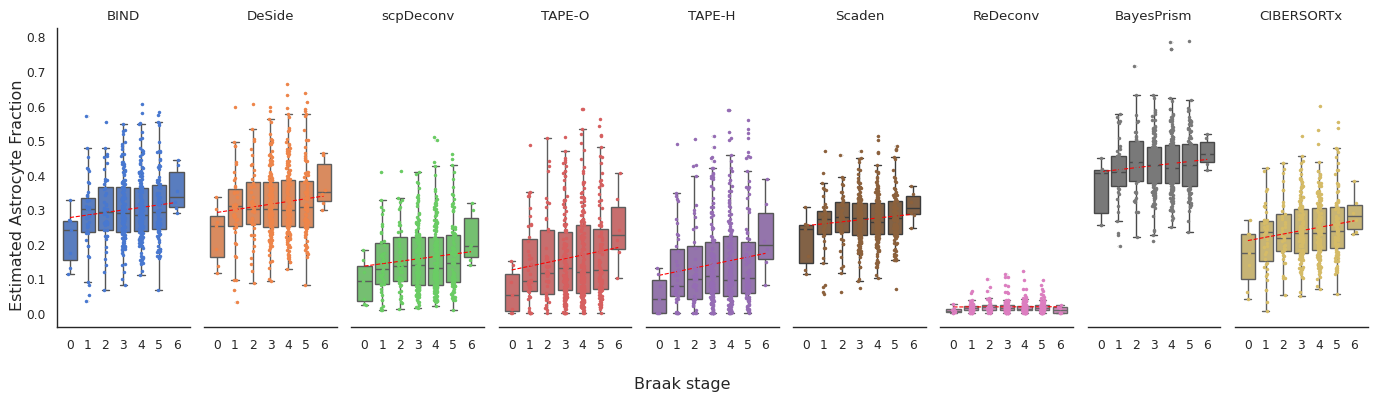

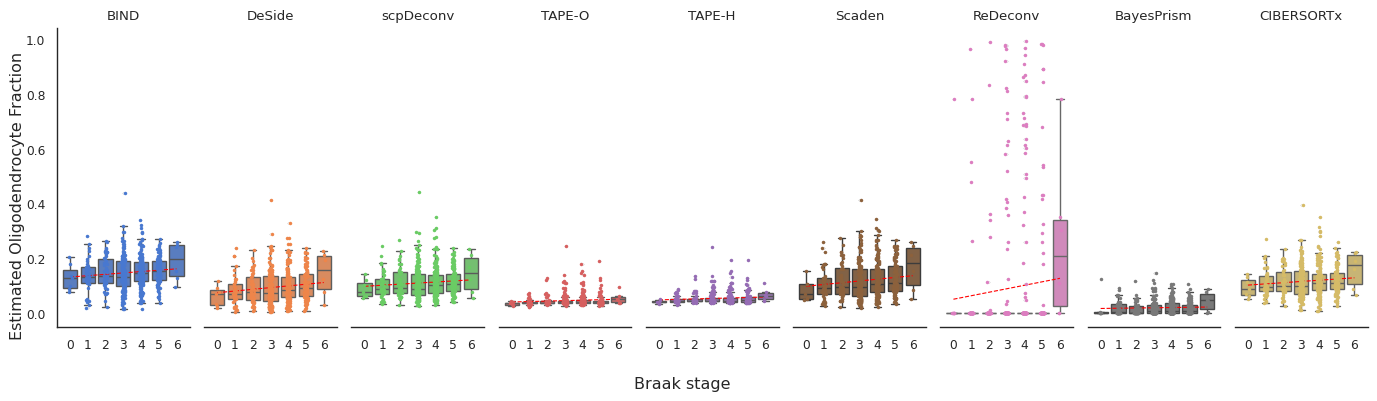

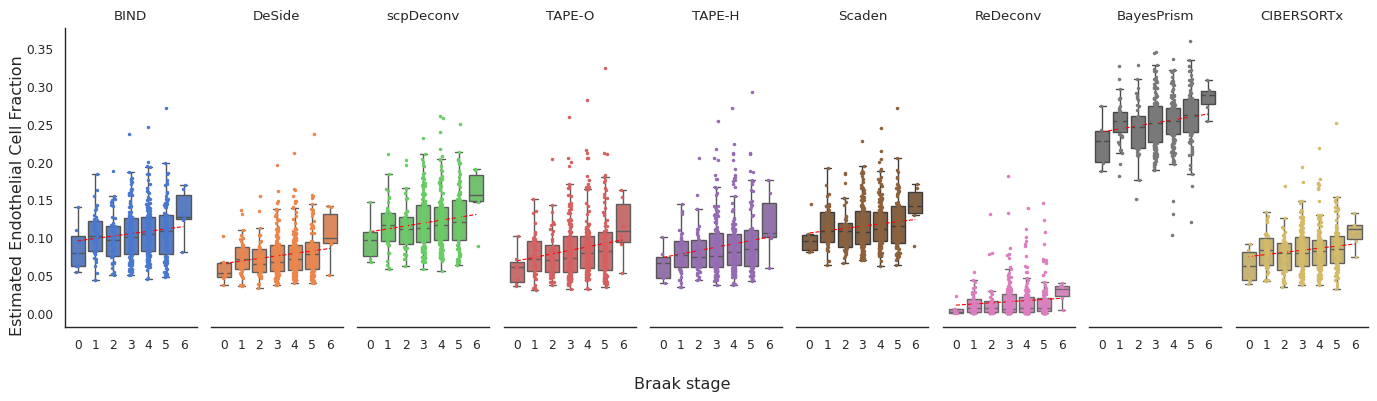

In [18]:
plot_trend_box(data, name, x='braaksc', y='Neurons', xlabel='Braak stage', ylabel='Estimated Neuron Fraction',
               filename='../results/plot/Brain_human_neuron_braak')
plot_trend_box(data, name, x='braaksc', y='Astrocytes', xlabel='Braak stage', ylabel='Estimated Astrocyte Fraction',
               filename='../results/plot/Brain_human_astrocyte_braak')
plot_trend_box(data, name, x='braaksc', y='Oligodendrocytes', xlabel='Braak stage',
               ylabel='Estimated Oligodendrocyte Fraction',
               filename='../results/plot/Brain_human_oligodendrocyte_braak')
plot_trend_box(data, name, x='braaksc', y='Endothelial', xlabel='Braak stage', ylabel='Estimated Endothelial Cell Fraction',
               filename='../results/plot/Brain_human_endothelial_braak')

In [19]:
celltype_mapping = {
    'Astrocytes': 'Astrocyte',
    'Endothelial': 'Endothelial cell',
    'Microglia': 'Microglial cell',
    'Neurons': 'Neuron',
    'Oligodendrocytes': 'Oligodendrocyte'
}
BIND_renamed = BIND.rename(columns=celltype_mapping)

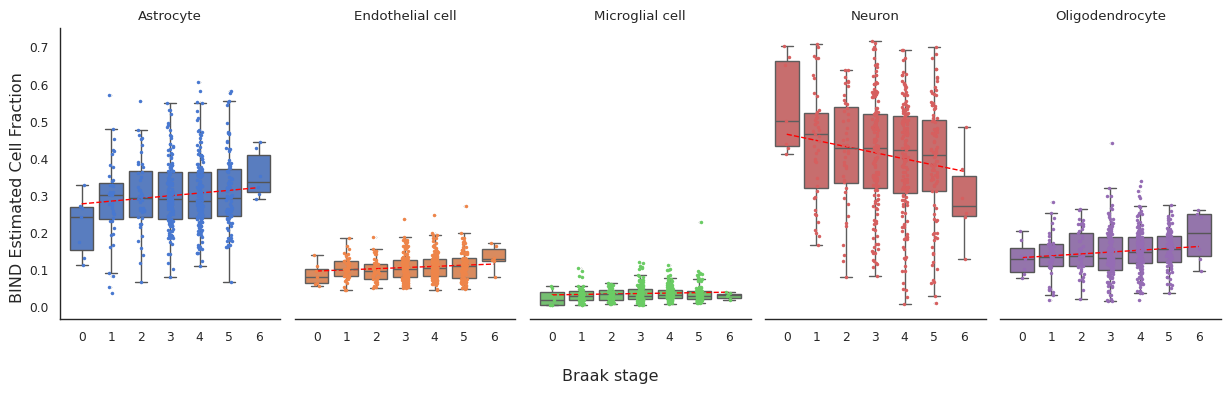

In [20]:
def plot_all_cell_types(method_data, x_col, xlabel, ylabel, filename):
    """
    为指定方法的数据中所有细胞类型绘制趋势箱线图。

    Args:
        method_data (pd.DataFrame): 包含一个方法预测结果的DataFrame。
                                    列应包括x轴的分类变量和各个细胞类型的比例。
        method_name (str):           方法的名字，将用作图表的总标题。
        x_col (str):                 用作x轴的列名 (例如 'braaksc').
        xlabel (str):                x轴的统一标签。
        ylabel (str):                y轴的统一标签。
        filename (str):              保存图片的文件名 (不含扩展名)。
    """
    sns.set_style("white")

    # 1. 自动识别所有细胞类型的列 (排除x轴列)
    cell_types = [col for col in method_data.columns if col != x_col]
    num_plots = len(cell_types)

    # 2. 根据细胞类型数量创建子图布局
    #    这里设置每行最多6个图，可以根据需要调整
    ncols = num_plots
    nrows = (num_plots - 1) // ncols + 1
    fig, axes = plt.subplots(nrows, num_plots,
                             figsize=(2.5 * ncols, 4 * nrows),
                             sharex=True, sharey=True,
                             squeeze=False) # squeeze=False 确保axes总是2D数组
    axes = axes.flatten() # 将axes数组展平，方便索引

    # 3. 遍历每种细胞类型并绘图
    for i, cell_type in enumerate(cell_types):
        ax = axes[i]

        # color = "#A9A9A9" # 使用统一的灰色调

        sns.stripplot(x=x_col, y=cell_type, data=method_data, ax=ax, color=colors[i], marker='.')
        sns.boxplot(x=x_col, y=cell_type, data=method_data, ax=ax, color=colors[i], fliersize=0.1, linewidth=1)

        # 添加回归趋势线
        sns.regplot(
            x=x_col, y=cell_type, data=method_data, ax=ax,
            ci=None,           # 不显示置信区间
            scatter=False,     # 不重复绘制散点
            color='red',       # 回归线颜色
            line_kws={'lw': 1, 'ls': '--'} # 线条样式
        )

        ax.set_title(cell_type) # 子图标题为细胞类型
        ax.set(xlabel=None, ylabel=None)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 只在第一列的图表上显示Y轴
        if i % ncols != 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_visible(False)

    # 隐藏多余的空子图
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    # fig.suptitle(method_name, fontsize=16, y=1.02) # 设置总标题为方法名
    fig.supxlabel(xlabel)
    fig.supylabel(ylabel)

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # 调整布局以适应总标题
    fig.savefig(f"{filename}.png", dpi=dpi, bbox_inches='tight')
    plt.show()
plot_all_cell_types(BIND_renamed, 'braaksc', 'Braak stage', 'BIND Estimated Cell Fraction', '../results/plot/Brain_human_BIND_braak')

## SARS-COV-2

In [21]:
"""
Rem: Remdesivir
SARS: SARS-Cov-2
mock: mock infection/negative control
"""
islet = pd.read_csv('../data/Real bulk/Islet.txt', sep='\t', index_col=0, header=0).T

BIND = pd.read_csv('../results/predicted/BIND/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
DeSide = pd.read_csv('../results/predicted/DeSide/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
BayesPrism = pd.read_csv('../results/predicted/BayesPrism/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
CIBERSORTX = pd.read_csv('../results/predicted/CIBERSORTx/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
CIBERSORTX.drop(columns=['P-value', 'Correlation', 'RMSE'], inplace=True)
ReDeconv = pd.read_csv('../results/predicted/ReDeconv/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
Scaden = pd.read_csv('../results/predicted/Scaden/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
scpDeconv = pd.read_csv('../results/predicted/scpDeconv/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
TAPE_O = pd.read_csv('../results/predicted/TAPE-O/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)
TAPE_H = pd.read_csv('../results/predicted/TAPE-H/Islet_GSE159717.txt', sep='\t', index_col=0, header=0)

In [22]:
BIND.index = islet.index
BayesPrism.index = islet.index
scpDeconv.index = islet.index

In [23]:
data_list = [BIND, DeSide, scpDeconv, TAPE_O, TAPE_H, Scaden, ReDeconv, BayesPrism, CIBERSORTX]
data_name_list = ['BIND', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']
tidy_data_list = []
for data, data_name in zip(data_list, data_name_list):
    df_beta = data[['beta']]
    df_beta['ID'] = data.index

    # 从ID列中解析出 Sample 和 Condition
    df_beta['Sample'] = df_beta['ID'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
    df_beta['Condition'] = df_beta['ID'].apply(lambda x: x.split('_')[2])

    # 添加方法名列
    df_beta['Method'] = data_name

    tidy_data_list.append(df_beta)

df_combined = pd.concat(tidy_data_list, ignore_index=True)
# df_combined.set_index('ID', inplace=True)

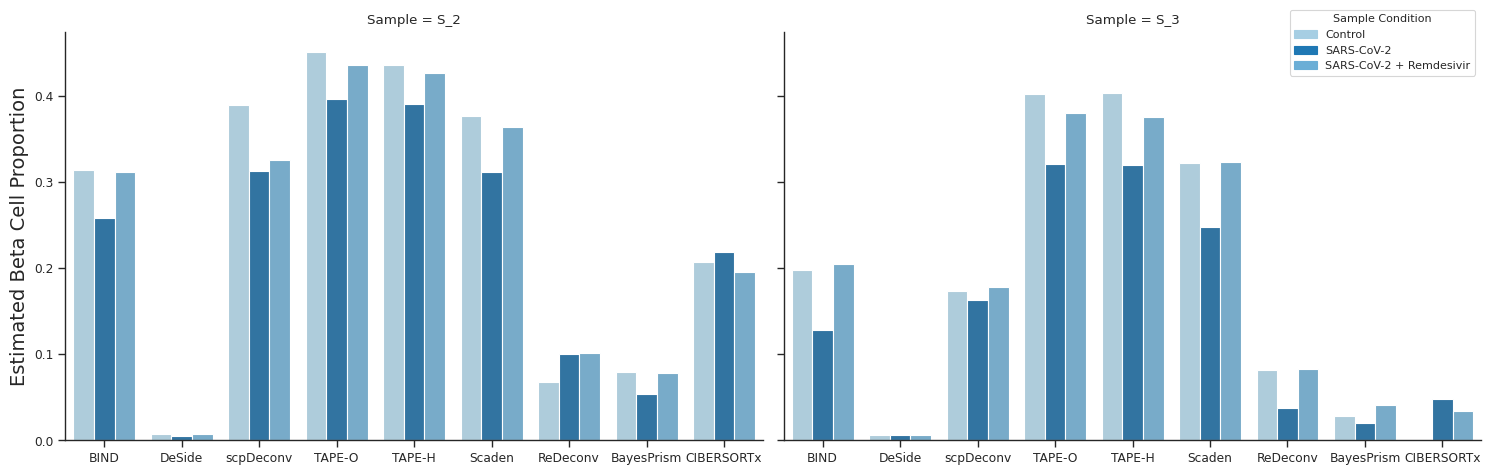

In [24]:
import matplotlib.patches as mpatches

# --- 2. 绘图代码 ---
method_order = data_name_list
condition_order = ['mock', 'SARS', 'Rem']
# palette = sns.color_palette("Paired", n_colors=len(condition_order))  # 明确颜色数量
palette = ['#a6cee3', '#1f78b4', '#6baed6']
sns.set_style("ticks")

# plt.figure(figsize=(12, 8))

g = sns.catplot(
    data=df_combined,
    kind='bar',
    x='Method',
    y='beta',
    hue='Condition',
    col='Sample',
    order=method_order,
    hue_order=condition_order,
    palette=palette,
    height=5,  # 每个子图高度
    aspect=1.5,  # 子图宽高比，调大会更宽
    legend=False
)

# --- 3. 美化图表 ---
# g.fig.suptitle('Comparison of Deconvolution Methods across Replicates', y=1.03, fontsize=18)  # 图标大标题
# for ax in g.axes.flat:  # 旋转标签
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
#     ax.set_xlabel(None)
g.set_axis_labels("", "Estimated Beta Cell Proportion", fontsize=14)

# --- 核心修改在这里 ---

# 1. 定义图例标签
label_map = {
    'mock': 'Control',
    'SARS': 'SARS-CoV-2',
    'Rem': 'SARS-CoV-2 + Remdesivir'
}
new_labels = [label_map.get(label, label) for label in condition_order]

# 2. 手动创建图例的“句柄”（即颜色方块）
#    我们直接从调色板里取颜色来创建 Patch 对象
handles = [mpatches.Patch(color=palette[i], label=new_labels[i]) for i in range(len(new_labels))]

# 3. 使用手动创建的 handles 和 new_labels 创建图例
g.fig.legend(
    handles=handles,
    # labels=new_labels, # 标签信息已包含在 Patch 对象中
    title='Sample Condition',
    loc='upper right',
    bbox_to_anchor=(0.99, 0.95),
    fontsize=8,
    title_fontsize=8
)

# 调整整体布局
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../results/plot/Islet.png', dpi=dpi, bbox_inches='tight')
plt.show()

## HGSC

In [25]:
BIND_pred = pd.read_csv('../results/predicted/BIND/HGSC.txt', sep='\t', index_col=0, header=0)
hgsc_clinical = pd.read_csv('../data/Real bulk/truth/HGSC_clinical_info.csv', index_col=0, header=0)
BIND_pred.index = hgsc_clinical.index
BIND_pred['response'] = hgsc_clinical['response']

In [26]:
# 删除CA-MSCs列和ECCs
BIND_pred.drop(['CA-MSCs', 'ECCs'], axis=1, inplace=True)

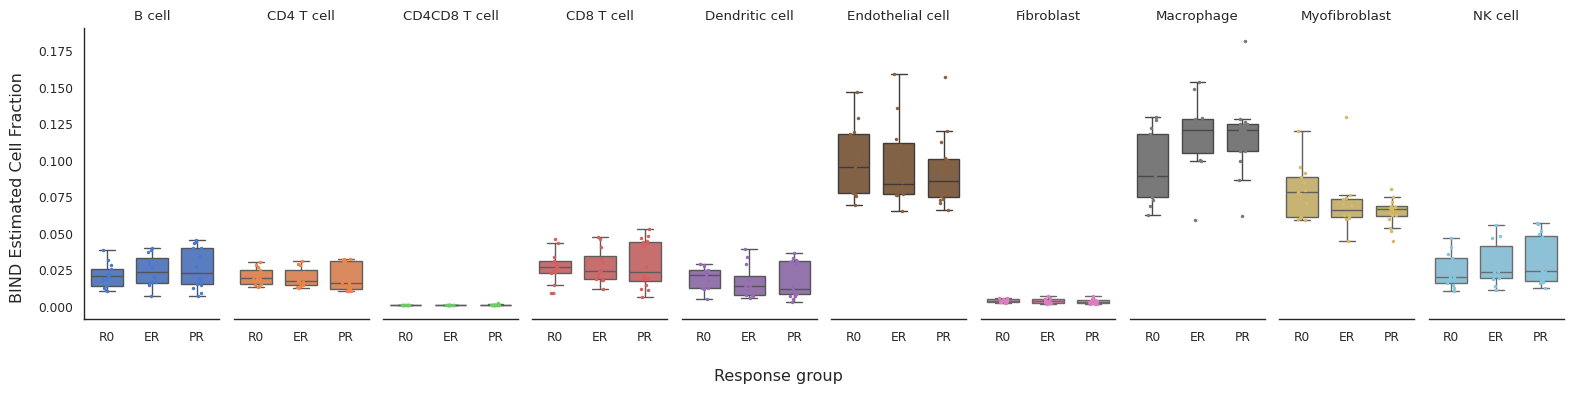

In [27]:
import textwrap  # 自动换行
stage_order_list = [
    'R0',
    'ER',
    'PR',
]

cell_type_mapping = {
    'B': 'B cell',
    'CA-MSCs': 'Cancer-associated mesenchymal stem cell',
    'CD4 T': 'CD4 T cell',
    'CD4CD8 T': 'CD4CD8 T cell',
    'CD8 T': 'CD8 T cell',
    'DCs': 'Dendritic cell',
    'ECCs': 'Epithelial cancer cell',
    'Endo': 'Endothelial cell',
    'Fibro': 'Fibroblast',
    'Macro': 'Macrophage',
    'Myofibro': 'Myofibroblast',
    'NK': 'NK cell'
}
BIND_pred.rename(columns=cell_type_mapping, inplace=True)

sns.set_style("white")

colors_hgsc = sns.color_palette("muted", 10)
colors_hgsc2 = sns.color_palette("husl", 3)
colors_hgsc = colors_hgsc + colors_hgsc2

# 1. 自动识别所有细胞类型的列 (排除x轴列)
cell_types = [col for col in BIND_pred.columns if col != 'response']
num_plots = len(cell_types)

# 2. 根据细胞类型数量创建子图布局
#    这里设置每行最多6个图，可以根据需要调整
ncols = num_plots
fig, axes = plt.subplots(1, num_plots,
                         figsize=(1.6 * ncols, 4),
                         sharex=True, sharey=True,
                         squeeze=False) # squeeze=False 确保axes总是2D数组
axes = axes.flatten() # 将axes数组展平，方便索引

# 3. 遍历每种细胞类型并绘图
for i, cell_type in enumerate(cell_types):
    if cell_type == 'response':
        continue
    ax = axes[i]

    # color = "#A9A9A9" # 使用统一的灰色调

    sns.stripplot(x='response', y=cell_type, data=BIND_pred, ax=ax, order=stage_order_list, color=colors_hgsc[i], marker='.')
    sns.boxplot(x='response', y=cell_type, data=BIND_pred, ax=ax, order=stage_order_list, color=colors_hgsc[i], fliersize=0.1, linewidth=1, width=0.7)

    # --- 这里是核心修改 ---
    # a. 设置一个合适的换行宽度 (可以根据需要调整)
    width_for_wrap = 22
    # b. 使用textwrap处理标题并设置
    wrapped_title = '\n'.join(textwrap.wrap(cell_type, width=width_for_wrap))
    ax.set_title(wrapped_title) # <-- 修改：使用换行后的标题
    # --- 修改结束 ---

    ax.set(xlabel=None, ylabel=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 只在第一列的图表上显示Y轴
    if i % ncols != 0:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)

# 隐藏多余的空子图
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# fig.suptitle(method_name, fontsize=16, y=1.02) # 设置总标题为方法名
fig.supxlabel('Response group')
fig.supylabel('BIND Estimated Cell Fraction')

plt.tight_layout(rect=[0.01, 0, 1, 0.98]) # 调整布局以适应总标题
fig.savefig('../results/plot/HGSC_BIND_stage.png', dpi=dpi, bbox_inches='tight')
plt.show()

## sEV

In [3]:
crc = pd.read_csv('../data/Real bulk/CRC-sEV.txt', sep='\t', index_col=0, header=0).T
crc.index = [i.split('.')[0] for i in crc.index]
BIND = pd.read_csv('../results/predicted/BIND/CRC-sEV_notFilter.txt', sep='\t', index_col=0, header=0)

sample = pd.read_csv('../data/Real bulk/truth/TCGA_CRC_gdc_sample_sheet.tsv', sep='\t')

sample_dict = dict(zip(sample['Sample ID'], sample['Tissue Type']))
crc['Tissue Type'] = crc.index.map(sample_dict)
BIND.index = crc['Tissue Type']
BIND['sample'] = crc.index

In [4]:
BIND.head()

,Others,sEV,sample
Tissue Type,,,
Tumor,0.999996,0.000004,TCGA-A6-6780-01A
Tumor,0.999996,0.000004,TCGA-CM-5868-01A
Tumor,0.999996,0.000004,TCGA-CM-6165-01A
Tumor,0.999962,0.000038,TCGA-AA-3956-01A
Tumor,0.999905,0.000095,TCGA-AA-3527-01A


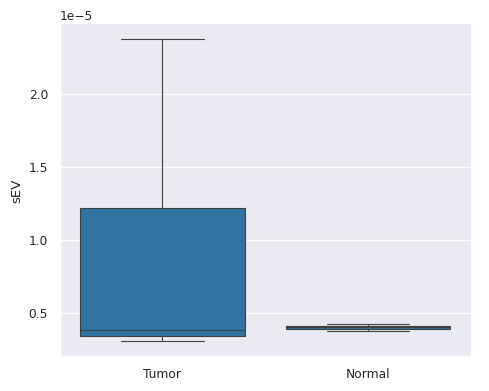

In [5]:
g = sns.catplot(
    x="Tissue Type", y="sEV",
    data=BIND,
    kind="box",
    # palette=colors,
    height=4,
    aspect=1.2,
    showfliers=False,
    linewidth=0.8,  # 轮廓线宽度
)
# 设置子图的标题和Y轴标签
g.set_titles("{col_name}")
g.set_ylabels("sEV")
# 遍历每个子图的 axes，进行精细调整
for ax in g.axes.flat:
    # 旋转每个子图的X轴刻度标签
    # ax.tick_params(axis='x', labelrotation=45)
    # 为每个子图设置X轴的标题
    # ax.set_xlabel("Method")
    ax.set_xlabel("")
# 调整整体布局，防止标签或标题重叠
plt.tight_layout()
# 如果需要保存图片
# plt.savefig(f"{filename}_MAE.png", dpi=dpi, bbox_inches='tight')
plt.show()

## T2D

In [39]:
pancreas_clinical = pd.read_csv('../data/Real bulk/truth/GSE50244_clinical.csv', index_col=0, header=0)

BIND = pd.read_csv('../results/predicted/BIND/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
DeSide = pd.read_csv('../results/predicted/DeSide/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
BayesPrism = pd.read_csv('../results/predicted/BayesPrism/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
CIBERSORTX = pd.read_csv('../results/predicted/CIBERSORTx/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
CIBERSORTX.drop(columns=['P-value', 'Correlation', 'RMSE'], inplace=True)
ReDeconv = pd.read_csv('../results/predicted/ReDeconv/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
Scaden = pd.read_csv('../results/predicted/Scaden/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
scpDeconv = pd.read_csv('../results/predicted/scpDeconv/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
TAPE_O = pd.read_csv('../results/predicted/TAPE-O/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)
TAPE_H = pd.read_csv('../results/predicted/TAPE-H/Pancreas_GSE50244.txt', sep='\t', index_col=0, header=0)

In [40]:
BIND.index = pancreas_clinical.index
DeSide.index = pancreas_clinical.index
BayesPrism.index = pancreas_clinical.index
CIBERSORTX.index = pancreas_clinical.index
ReDeconv.index = pancreas_clinical.index
Scaden.index = pancreas_clinical.index
scpDeconv.index = pancreas_clinical.index
TAPE_O.index = pancreas_clinical.index
TAPE_H.index = pancreas_clinical.index

In [41]:
BIND = BIND.join(pancreas_clinical)
DeSide = DeSide.join(pancreas_clinical)
BayesPrism = BayesPrism.join(pancreas_clinical)
CIBERSORTX = CIBERSORTX.join(pancreas_clinical)
ReDeconv = ReDeconv.join(pancreas_clinical)
Scaden = Scaden.join(pancreas_clinical)
scpDeconv = scpDeconv.join(pancreas_clinical)
TAPE_O = TAPE_O.join(pancreas_clinical)
TAPE_H = TAPE_H.join(pancreas_clinical)

In [42]:
BIND.head()

,acinar,alpha,beta,delta,ductal,gamma,Sample,tissue,age,bmi,gender,year of birth,hba1c
id,,,,,,,,,,,,,
1,0.235093,0.216245,0.067932,0.289959,0.152753,0.038018,GSM1216753,pancreatic islets,69,24.7,Male,1939,5.8
2,0.150416,0.338649,0.069754,0.337890,0.079099,0.024192,GSM1216754,pancreatic islets,56,24.7,Male,1952,NaN
3,0.300605,0.211060,0.067319,0.330959,0.076126,0.013932,GSM1216755,pancreatic islets,46,23.9,Female,1962,5.4
4,0.179337,0.222024,0.096468,0.335060,0.078726,0.088385,GSM1216756,pancreatic islets,62,27.7,Female,1946,NaN
5,0.324062,0.143436,0.072732,0.308299,0.138069,0.013402,GSM1216757,pancreatic islets,70,17.6,Female,1939,NaN


In [43]:
data = [BIND, DeSide, scpDeconv, TAPE_O, TAPE_H, Scaden, ReDeconv, BayesPrism, CIBERSORTX]
name = ['BIND', 'DeSide', 'scpDeconv', 'TAPE-O', 'TAPE-H', 'Scaden', 'ReDeconv', 'BayesPrism', 'CIBERSORTx']

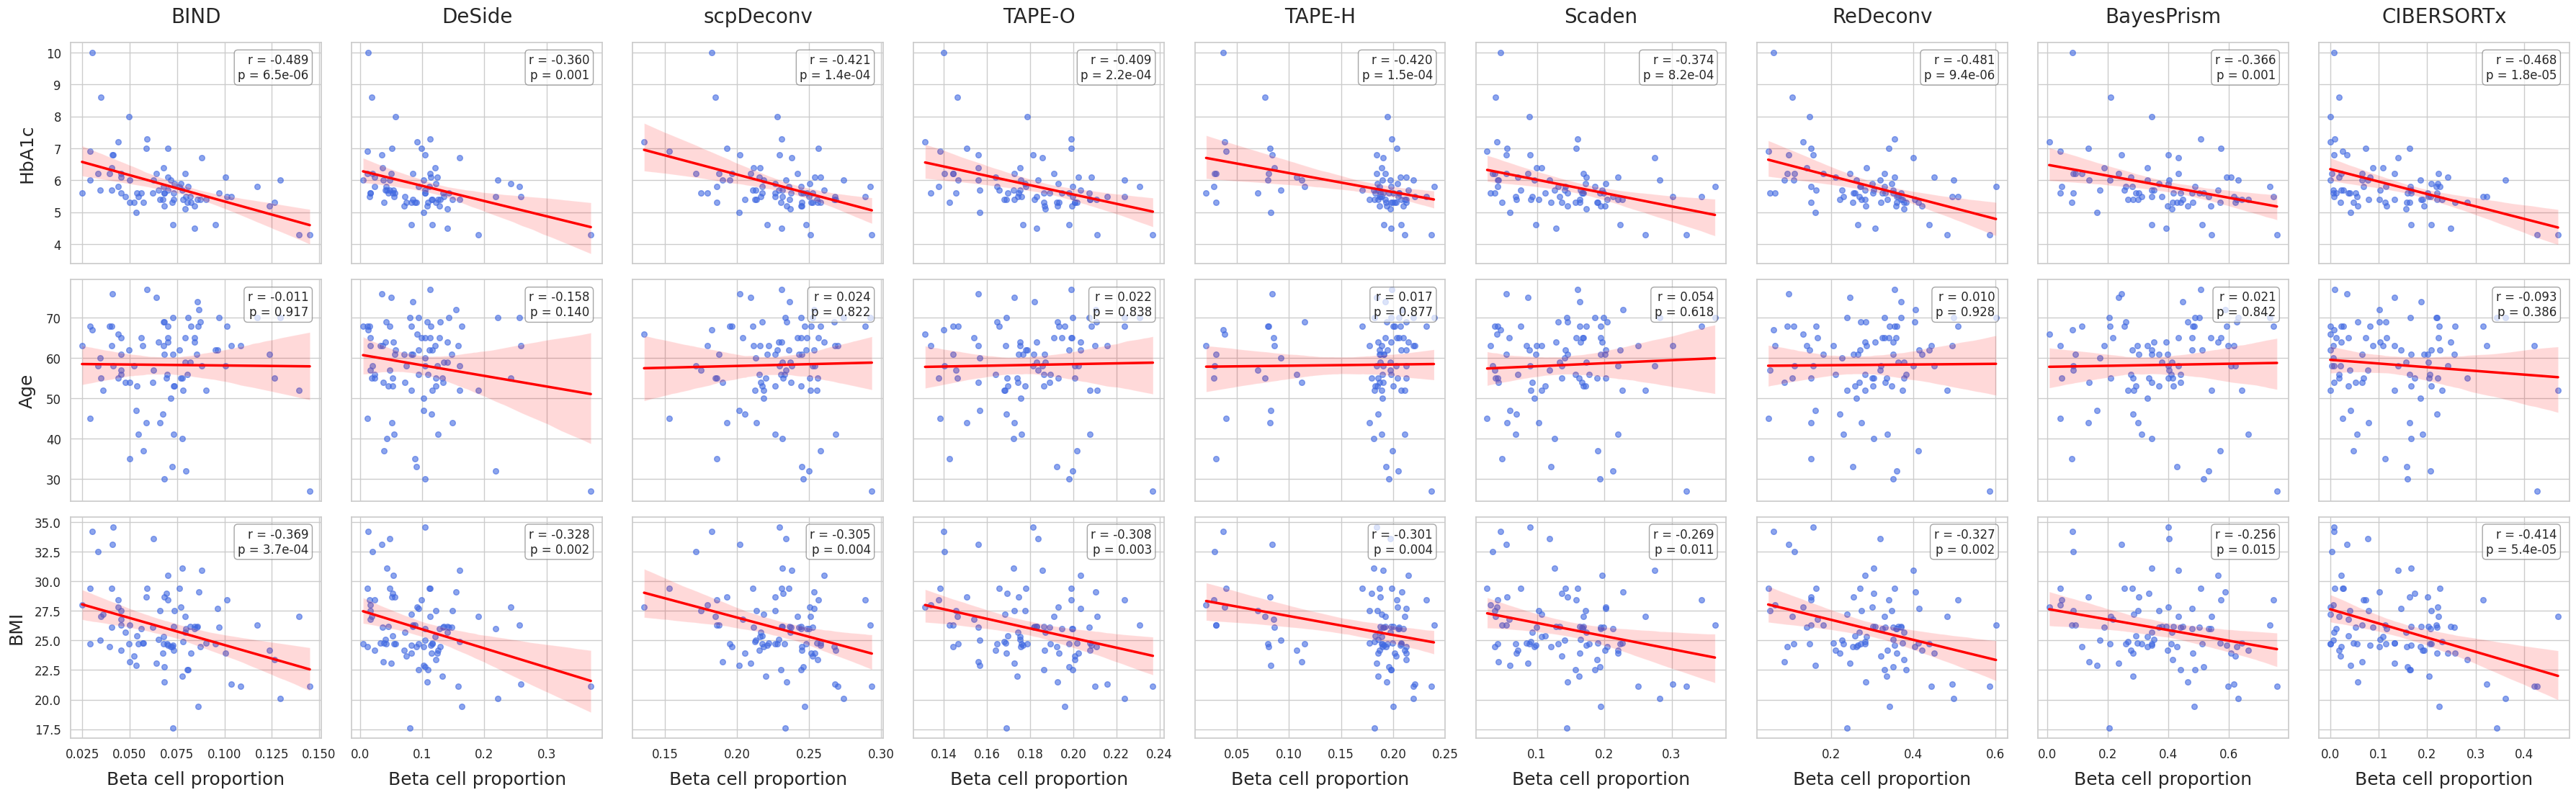

In [44]:
from scipy.stats import pearsonr
sns.set_theme(style="whitegrid", font_scale=1.2)

# Define the clinical variables for each row
y_variables = ['hba1c', 'age', 'bmi']
y_labels_english = ['HbA1c', 'Age', 'BMI']

# Create a 3x9 subplot grid.
fig, axes = plt.subplots(3, 9, figsize=(36, 12), sharex='col', sharey='row')

# Main loop: iterate through each method (column)
for col_idx, (df, method_name) in enumerate(zip(data, name)):

    # Set the column title on the top-most subplot
    axes[0, col_idx].set_title(method_name, fontsize=20, pad=20)

    # Inner loop: iterate through each clinical variable (row)
    for row_idx, y_var in enumerate(y_variables):
        ax = axes[row_idx, col_idx]

        # Data Preparation
        df_filtered = df.dropna(subset=['beta', y_var]).copy()
        df_filtered['beta'] = pd.to_numeric(df_filtered['beta'], errors='coerce')
        df_filtered[y_var] = pd.to_numeric(df_filtered[y_var], errors='coerce')
        df_filtered.dropna(subset=['beta', y_var], inplace=True)

        x_data = df_filtered['beta']
        y_data = df_filtered[y_var]

        # Statistics
        stats_text = 'n.s.' # not significant, default text
        if len(df_filtered) > 2:
            r, p_value = pearsonr(x_data, y_data)
            p_text = f'{p_value:.1e}' if p_value < 0.001 else f'{p_value:.3f}'
            stats_text = f'r = {r:.3f}\np = {p_text}'

        # Plotting
        sns.regplot(
            x=x_data,
            y=y_data,
            ax=ax,
            scatter_kws={'alpha': 0.6, 's': 30, 'color': 'royalblue'},
            line_kws={'color': 'red', 'linewidth': 2.5}
        )

        # Add stats text
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7))

        # Axis Labels (decluttering)
        if col_idx == 0:
            ax.set_ylabel(y_labels_english[row_idx], fontsize=18, labelpad=10)
        else:
            ax.set_ylabel('')

        if row_idx == 2:
            ax.set_xlabel('Beta cell proportion', fontsize=18, labelpad=10)
        else:
            ax.set_xlabel('')

        # Tick label font size
        ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # Adjust rect to make space for titles
# fig.suptitle('Correlation of Beta Cell Proportion with Clinical Variables Across Deconvolution Methods', fontsize=28, y=1.0)

# --- 3. Save the Figure ---
plt.savefig("../results/plot/Pancreas_beta_cell_correlations.png", dpi=dpi, bbox_inches='tight')
# plt.savefig("../results/plot/Pancreas_beta_cell_correlations_300dpi.png", dpi=300, bbox_inches='tight')

plt.show()

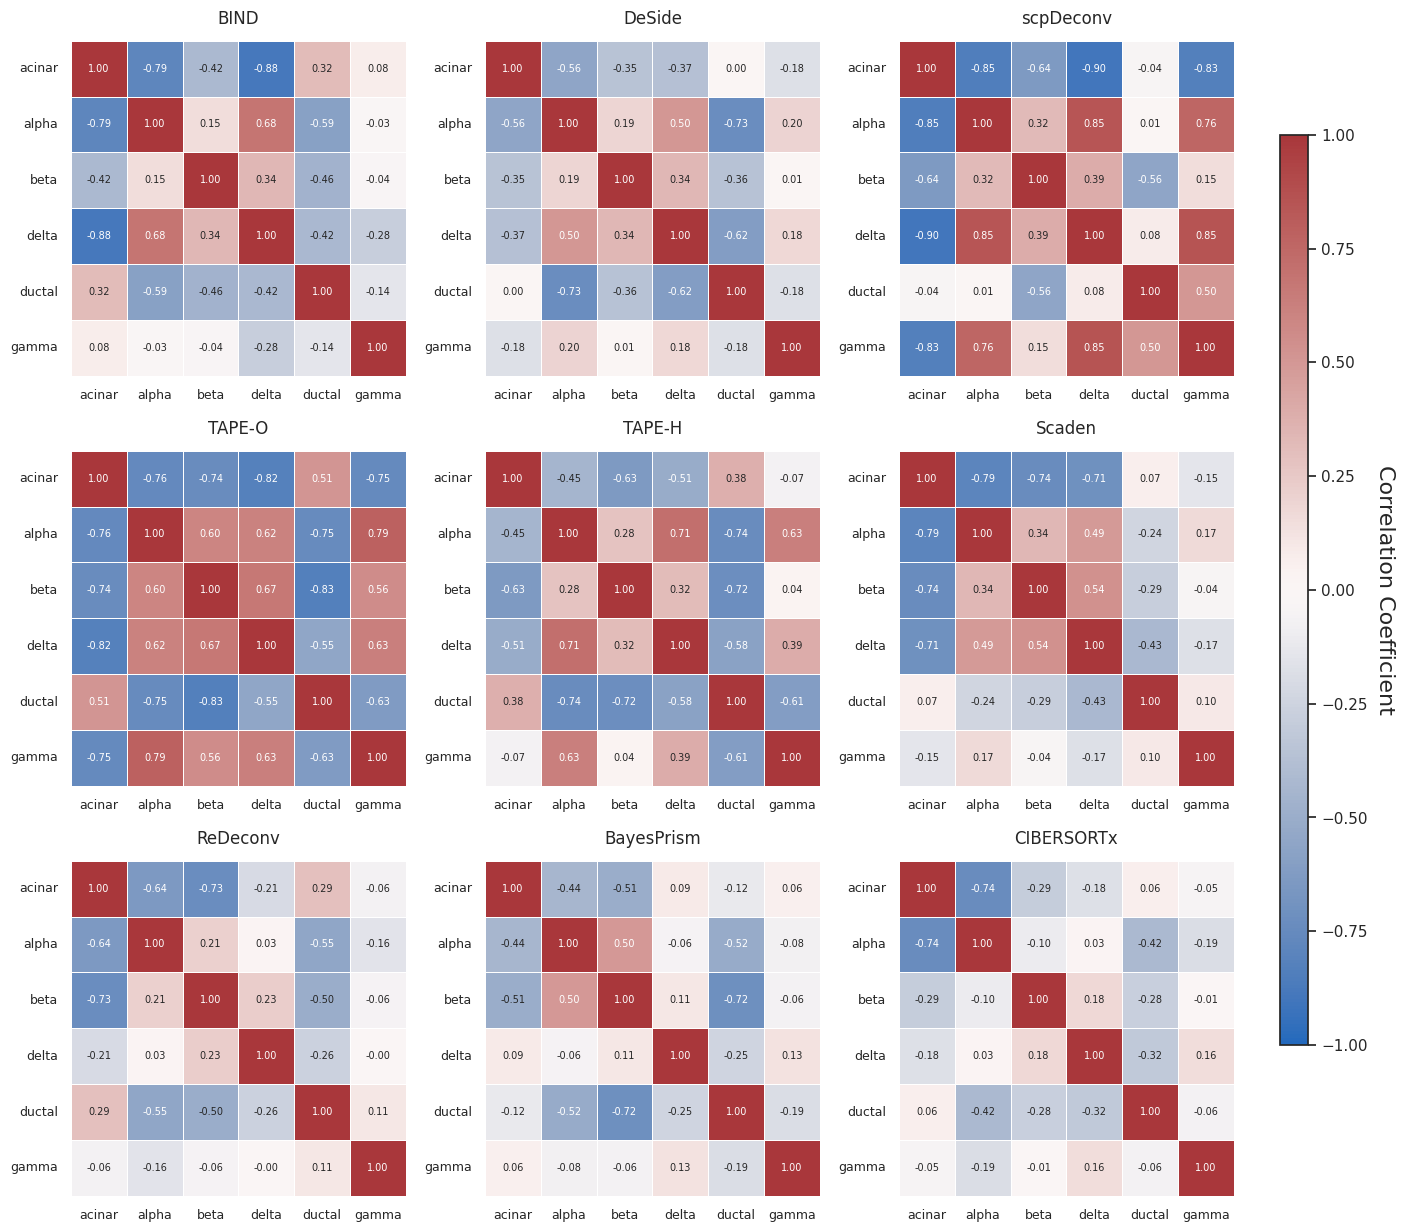

In [45]:
cell_type_columns = ['acinar', 'alpha', 'beta', 'delta', 'ductal', 'gamma']
sns.set_theme(style="white", font_scale=1.0)
fig, axes = plt.subplots(3, 3, figsize=(14, 13)) # Adjusted figsize slightly
axes = axes.flatten()

# --- MODIFICATION 1 ---
# Create a mappable object for the color bar. This will be used later.
# We define the normalization and colormap that all heatmaps will share.
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap('vlag')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # You have to set a dummy array for this to work.

for i, (df, method_name) in enumerate(zip(data, name)):
    ax = axes[i]
    df_cells = df[cell_type_columns]
    corr_matrix = df_cells.corr()

    # --- MODIFICATION 2 ---
    # In the heatmap call, we:
    # 1. Set `cbar=False` to disable individual color bars.
    # 2. Use `annot_kws` to set a smaller font size for the numbers.
    sns.heatmap(
        corr_matrix,
        ax=ax,
        annot=True,
        annot_kws={"fontsize": 7}, # 数字大小
        fmt=".2f",
        cmap=cmap,                 # Use the shared colormap
        norm=norm,                 # Use the shared normalization
        linewidths=.5,
        cbar=False                 # Disable individual color bars
    )

    ax.set_title(method_name, fontsize=12, pad=12)  # 方法名称大小
    ax.tick_params(axis='y', rotation=0)

    # Set the font size for the axis tick labels (cell names)
    # and ensure the y-axis labels are horizontal.
    ax.tick_params(axis='y', rotation=0, labelsize=9)  # 细胞标签大小
    ax.tick_params(axis='x', labelsize=9)

for j in range(len(data), len(axes)):
    axes[j].set_visible(False)

# Adjust main layout to make space on the right for the color bar
plt.tight_layout(rect=[0, 0, 0.9, 0.96]) # rect=[left, bottom, right, top]

# --- MODIFICATION 3 ---
# Add a single, shared color bar to the figure
# We add a new axes to the figure where the color bar will live.
# The numbers are [left, bottom, width, height] in figure coordinates.
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=16)

# fig.suptitle('Inter-Cell Type Correlation Across Deconvolution Methods', fontsize=24)

# --- 3. Save the Figure ---
plt.savefig("../results/plot/Pancreas_cell_type_correlation_heatmap.png", dpi=dpi, bbox_inches='tight')

plt.show()